The goal of this notebook is just to gain an understanding on how Bayesian Optimization works.  
Codes are mostly taken from [this tutorial](http://krasserm.github.io/2018/03/21/bayesian-optimization/).  
  
## Theory

#### Overall framework of Bayesian Optimization algorithm
For each `t = 1, 2, 3 .. `, repeat:  
- Find the next sampling point `x[t]` by optimizing the acquisition function over the Gaussian Process (GP):
    - `x[t] = argmax(acquisition_function(x, D))` over `x`
- Obtain a noisy sample `y[t] = f(x[t])` from the objective function `f`.
- Add the sample `(x[t], f(x[t]))` to the previous samples and update the GP. 

#### Acquisition functions
Popular acquisition functions are **maximum probability of improvement (MPI)**, **expected improvement (EI)** and **upper confidence bound (UCB)**.

## Set up dummy objective function

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# debugger
import pdb

%matplotlib inline

In [36]:
bounds = np.array([[-1.0, 2.0]])
noise = 0.2

def f(X, noise=noise):
    return -np.sin(3*X) - X**2 + 0.7*X + noise * np.random.randn(*X.shape)

X_init = np.array([[-0.9], [1.1]])
Y_init = f(X_init)

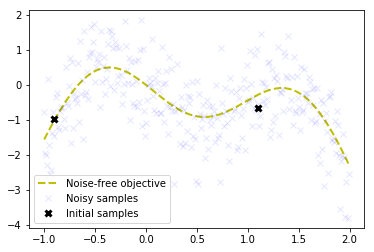

In [16]:
# Dense grid of points within bounds
X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)

# Noise-free objective function values at X 
Y = f(X,0)

# Plot optimization objective with noise level 
plt.plot(X, Y, 'y--', lw=2, label='Noise-free objective')
plt.plot(X, f(X), 'bx', lw=1, alpha=0.1, label='Noisy samples')
plt.plot(X_init, Y_init, 'kx', mew=3, label='Initial samples')
plt.legend();

In [25]:
from scipy.stats import norm

def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.1):
    ''' Computes the EI at points X based on existing samples X_sample and Y_sample using a Gaussian process surrogate model. Args: X: Points at which EI shall be computed (m x d). X_sample: Sample locations (n x d). Y_sample: Sample values (n x 1). gpr: A GaussianProcessRegressor fitted to samples. xi: Exploitation-exploration trade-off parameter. Returns: Expected improvements at points X. '''
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)

    sigma = sigma.reshape(-1, X_sample.shape[1])
    
    # Needed for noise-based model,
    # otherwise use np.max(Y_sample).
    # See also section 2.4 in [...]
    mu_sample_opt = np.max(mu_sample)

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei

In [26]:
from scipy.optimize import minimize

def propose_location(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=25):
    ''' Proposes the next sampling point by optimizing the acquisition function. Args: acquisition: Acquisition function. X_sample: Sample locations (n x d). Y_sample: Sample values (n x 1). gpr: A GaussianProcessRegressor fitted to samples. Returns: Location of the acquisition function maximum. '''
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None
    
    def min_obj(X):
        # Minimization objective is the negative acquisition function
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr)
    
    # Find the best optimum by starting from n_restart different random points.
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')      
        
        # if we found a better optimal objective function value, update it
        if res.fun < min_val:
            min_val = res.fun[0]
            min_x = res.x           
            
    return min_x.reshape(-1, 1)

In [27]:
# functions for plotting 
def plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next=None, show_legend=False):
    mu, std = gpr.predict(X, return_std=True)
    plt.fill_between(X.ravel(), 
                     mu.ravel() + 1.96 * std, 
                     mu.ravel() - 1.96 * std, 
                     alpha=0.1) 
    plt.plot(X, Y, 'y--', lw=1, label='Noise-free objective')
    plt.plot(X, mu, 'b-', lw=1, label='Surrogate function')
    plt.plot(X_sample, Y_sample, 'kx', mew=3, label='Noisy samples')
    if X_next:
        plt.axvline(x=X_next, ls='--', c='k', lw=1)
    if show_legend:
        plt.legend()

def plot_acquisition(X, Y, X_next, show_legend=False):
    plt.plot(X, Y, 'r-', lw=1, label='Acquisition function')
    plt.axvline(x=X_next, ls='--', c='k', lw=1, label='Next sampling location')
    if show_legend:
        plt.legend()    
        
def plot_convergence(X_sample, Y_sample, n_init=2):
    plt.figure(figsize=(12, 3))

    x = X_sample[n_init:].ravel()
    y = Y_sample[n_init:].ravel()
    r = range(1, len(x)+1)
    
    x_neighbor_dist = [np.abs(a-b) for a, b in zip(x, x[1:])]
    y_max_watermark = np.maximum.accumulate(y)
    
    plt.subplot(1, 2, 1)
    plt.plot(r[1:], x_neighbor_dist, 'bo-')
    plt.xlabel('Iteration')
    plt.ylabel('Distance')
    plt.title('Distance between consecutive x\'s')

    plt.subplot(1, 2, 2)
    plt.plot(r, y_max_watermark, 'ro-')
    plt.xlabel('Iteration')
    plt.ylabel('Best Y')
    plt.title('Value of best selected sample')

Iteration 1
X_sample: 
 [[-0.9]
 [ 1.1]]
Y_sample: 
 [[-0.96796775]
 [-0.66432648]]


Iteration 2
X_sample: 
 [[-0.9      ]
 [ 1.1      ]
 [ 1.9438891]]
Y_sample: 
 [[-0.96796775]
 [-0.66432648]
 [-1.0687154 ]]


Iteration 3
X_sample: 
 [[-0.9       ]
 [ 1.1       ]
 [ 1.9438891 ]
 [-0.87370583]]
Y_sample: 
 [[-0.96796775]
 [-0.66432648]
 [-1.0687154 ]
 [-1.91417676]]


Iteration 4
X_sample: 
 [[-0.9       ]
 [ 1.1       ]
 [ 1.9438891 ]
 [-0.87370583]
 [ 1.88343291]]
Y_sample: 
 [[-0.96796775]
 [-0.66432648]
 [-1.0687154 ]
 [-1.91417676]
 [-0.9475531 ]]


Iteration 5
X_sample: 
 [[-0.9       ]
 [ 1.1       ]
 [ 1.9438891 ]
 [-0.87370583]
 [ 1.88343291]
 [ 1.97940352]]
Y_sample: 
 [[-0.96796775]
 [-0.66432648]
 [-1.0687154 ]
 [-1.91417676]
 [-0.9475531 ]
 [-3.39380973]]


Iteration 6
X_sample: 
 [[-0.9       ]
 [ 1.1       ]
 [ 1.9438891 ]
 [-0.87370583]
 [ 1.88343291]
 [ 1.97940352]
 [-0.82835692]]
Y_sample: 
 [[-0.96796775]
 [-0.66432648]
 [-1.0687154 ]
 [-1.91417676]
 [-0.9475531 ]


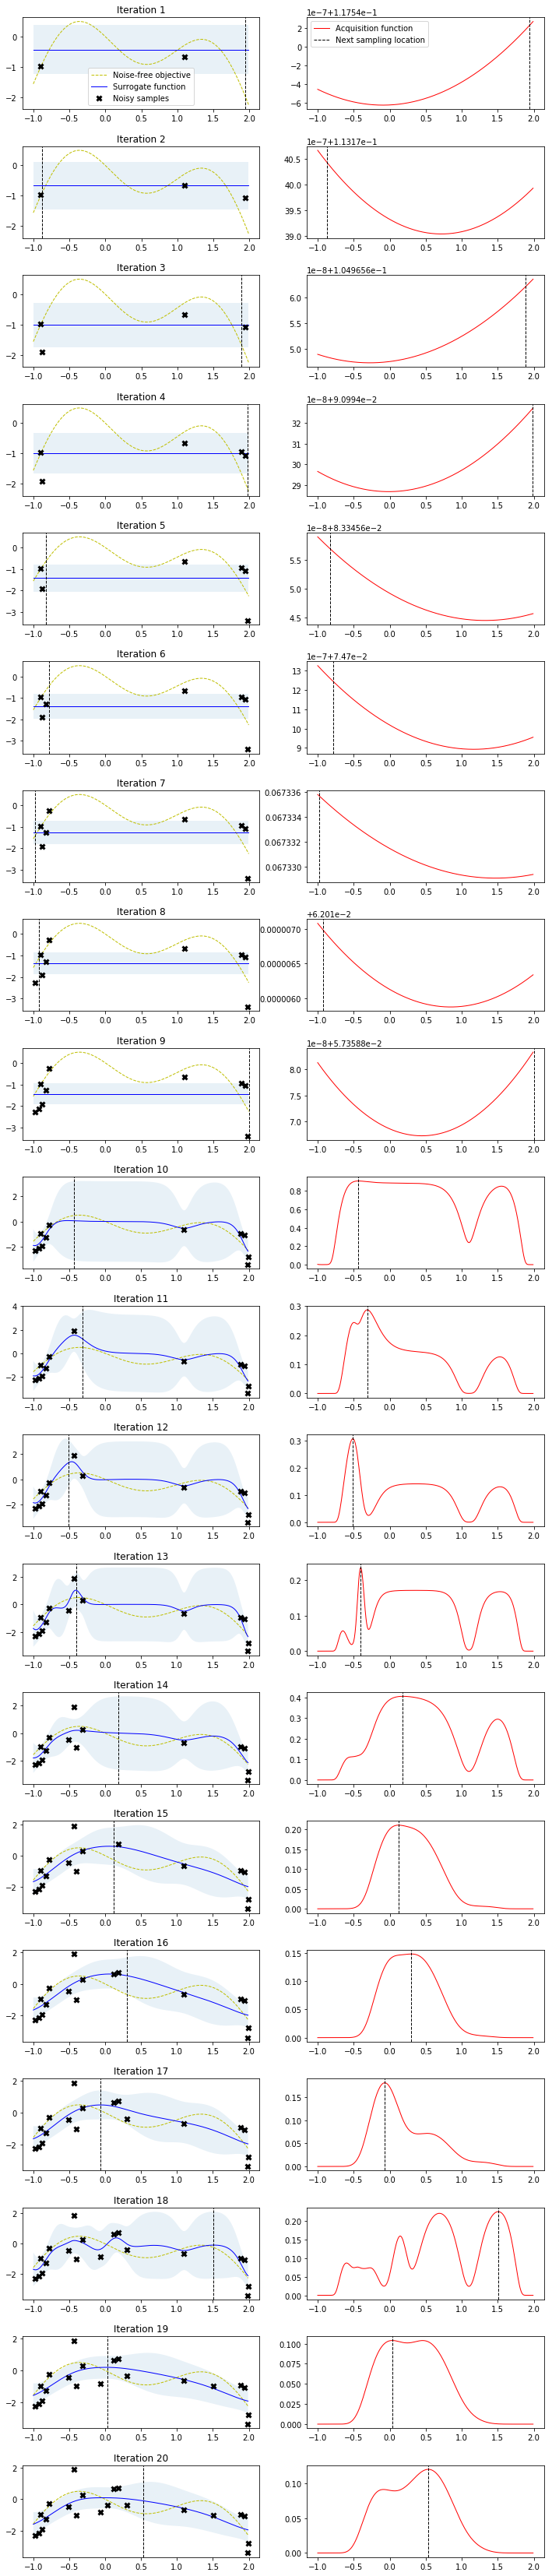

In [29]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern

# Gaussian process with Mat??rn kernel as surrogate model
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

# Initialize samples
X_sample = X_init
Y_sample = Y_init

# Number of iterations
n_iter = 20

plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)

for i in range(n_iter):
    print("Iteration {}".format(i+1))
    print("X_sample: \n {}".format(X_sample))
    print("Y_sample: \n {}".format(Y_sample))
    
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)
    
    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next = propose_location(expected_improvement, X_sample, Y_sample, gpr, bounds)
    
    # Obtain next noisy sample from the objective function
    Y_next = f(X_next, noise)
    
    # Plot samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next, show_legend=i==0)
    plt.title("Iteration {}".format(i + 1))

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition(X, expected_improvement(X, X_sample, Y_sample, gpr), X_next, show_legend=i==0)
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))
    
    print("\n")

## Testing out packages with Bayesian Optimization

**scikit-optimize** library

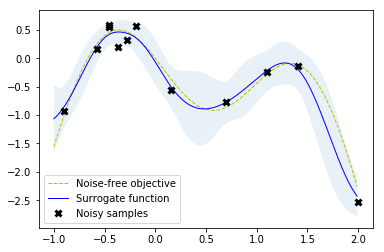

In [50]:
from sklearn.base import clone
from skopt import gp_minimize
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import ConstantKernel, Matern

# Use custom kernel and estimator to match previous example
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise ** 2)

r = gp_minimize(lambda x: -f(np.array(x))[0], 
                bounds.tolist(),
                base_estimator=gpr,
                acq_func='EI',      # expected improvement
                xi=0.1,            # exploitation-exploration trade-off
                n_calls=10,         # number of iterations
                n_random_starts=0,  # initial samples are provided
                x0=X_init.tolist(), # initial samples
                y0=-Y_init.ravel())

# Fit GP model to samples for plotting results
gpr.fit(r.x_iters, -r.func_vals)

# Plot the fitted model and the noisy samples
plot_approximation(gpr, X, Y, r.x_iters, -r.func_vals, show_legend=True)

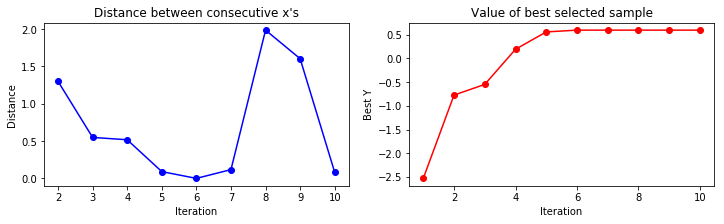

In [51]:
plot_convergence(np.array(r.x_iters), -r.func_vals)

In [59]:
(r.x[0], -1 * r.fun)

(-0.4584813200570075, 0.5943435990200002)

**GPyOpt** library

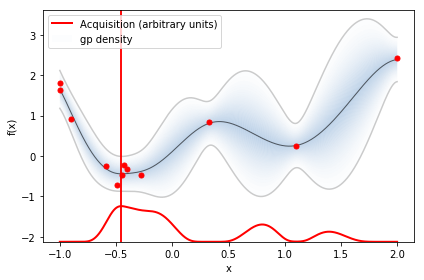

In [64]:
import GPy
import GPyOpt

from GPyOpt.methods import BayesianOptimization

kernel = GPy.kern.Matern52(input_dim=1, variance=1.0, lengthscale=1.0)
bds = [{'name': 'X', 'type': 'continuous', 'domain': bounds.ravel()}]

optimizer = BayesianOptimization(f=f, 
                                 domain=bds,
                                 model_type='GP',
                                 kernel=kernel,
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.01,
                                 X=X_init,
                                 Y=-Y_init,
                                 noise_var = noise**2,
                                 exact_feval=False,
                                 normalize_Y=False,
                                 maximize=True)

optimizer.run_optimization(max_iter=10)
optimizer.plot_acquisition()

In [73]:
# optimal value
optimizer.fx_opt

-0.7103327176288868